In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, Dropout, Input, concatenate, Reshape
from tensorflow.keras.models import Model


In [ ]:
SIZE = 128
classes = ['Healthy', 'Fracture', 'pathological lesion', 'caries']
image_directory = "/content/drive/MyDrive/dental cropped data/croped dataset/croped dataset"

flattened_data = []
labels = []

for label_index, class_name in enumerate(classes):
    class_path = os.path.join(image_directory, class_name)
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = cv2.imread(os.path.join(class_path, img_name), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (SIZE, SIZE))
            flat = img.flatten()
            flattened_data.append(flat)
            labels.append(label_index)

flattened_data = np.array(flattened_data)
labels = np.array(labels)

# Save CSV
df = pd.DataFrame(flattened_data)
df['label'] = labels
df.to_csv("/content/dental_flattened.csv", index=False)

# Prepare CSV input
X_csv = flattened_data.astype('float32') / 255.0
y_cat = to_categorical(labels, num_classes=4)


In [ ]:
import pandas as pd

# Read CSV
df = pd.read_csv("/content/dental_flattened.csv")

# Check shape
print("Shape of CSV:", df.shape)


Shape of CSV: (371, 16385)


In [ ]:
images_2d = []

for label_index, class_name in enumerate(classes):
    class_path = os.path.join(image_directory, class_name)
    for img_name in os.listdir(class_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img = cv2.imread(os.path.join(class_path, img_name), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (SIZE, SIZE))
            img = img.astype('float32') / 255.0
            img = np.expand_dims(img, axis=-1)
            images_2d.append(img)

images_2d = np.array(images_2d)

In [ ]:
x_csv_train, x_csv_val, x_img_train, x_img_val, y_train, y_val = train_test_split(
    X_csv, images_2d, y_cat,
    test_size=0.1,
    random_state=42,
    stratify=labels
)


In [ ]:
# CSV input branch (1D)
input1 = Input(shape=(16384,))
x1 = Reshape((16384, 1))(input1)
x1 = Conv1D(32, 3, activation='relu')(x1)
#x1 = MaxPooling1D(2)(x1)
x1 = Conv1D(64, 3, activation='relu')(x1)
x1 = MaxPooling1D(2)(x1)
x1 = Flatten()(x1)
x1 = Dense(128, activation='relu')(x1)
x1 = Dropout(0.3)(x1)

# Image input branch (2D)
input2 = Input(shape=(128, 128, 1))
x2 = Conv2D(32, (3,3), activation='relu', padding='same')(input2)
#x2 = MaxPooling2D((2,2))(x2)
x2 = Conv2D(64, (3,3), activation='relu', padding='same')(x2)
x2 = MaxPooling2D((2,2))(x2)
x2 = Conv2D(128, (3,3), activation='relu', padding='same')(x2)
#x2 = MaxPooling2D((2,2))(x2)
x2 = Flatten()(x2)
x2 = Dense(128, activation='relu')(x2)
x2 = Dropout(0.3)(x2)

# Merge branches
merged = concatenate([x1, x2])
z = Dense(128, activation='relu')(merged)
z = Dense(64, activation='relu')(z)
output = Dense(4, activation='softmax')(z)

model = Model(inputs=[input1, input2], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 16384)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 16384, 1)  │          0 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │        320 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 16382, 32) │        128 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │     18,496 │ conv2d_24[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 16380, 64) │      6,208 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 8190, 64)  │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 524160)    │          0 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 524288)    │          0 │ conv2d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │ 67,092,608 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 128)       │ 67,108,992 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 128)       │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 256)       │          0 │ dropout_24[0][0], │
│ (Concatenate)       │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     32,896 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │      8,256 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 4)         │        260 │ dense_33[0][0]  

 Total params: 134,342,020 (512.47 MB)

 Trainable params: 134,342,020 (512.47 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

# ---------------------------
# Learning Rate Scheduler
# ---------------------------
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.95  # decay slowly
lr_scheduler = LearningRateScheduler(scheduler)

# ---------------------------
# Reduce LR on plateau
# ---------------------------
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# ---------------------------
# Save best model
# ---------------------------
checkpoint = ModelCheckpoint(
    '/content/best_dental_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks_list = [lr_scheduler, reduce_lr, checkpoint]


In [ ]:
history = model.fit(
    [x_csv_train, x_img_train],
    y_train,
    validation_data=([x_csv_val, x_img_val], y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks_list
)


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.4031 - loss: 5.2234
Epoch 1: val_accuracy improved from -inf to 0.60526, saving model to /content/best_dental_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.4073 - loss: 5.1996 - val_accuracy: 0.6053 - val_loss: 0.9791 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5340 - loss: 1.1979
Epoch 2: val_accuracy did not improve from 0.60526
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.5343 - loss: 1.1893 - val_accuracy: 0.6053 - val_loss: 0.9349 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6202 - loss: 0.9227
Epoch 3: val_accuracy did not improve from 0.60526
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.6181 - loss: 0.9243 - val_accuracy: 0.6053 - val_loss: 0.8874 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6063 - loss: 0.8863
Epoch 4: val_accuracy did not improve from 0.60526
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.6103 - loss: 0.8851 - val_accuracy: 0.6053 - val_loss: 0.8070 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7323 - loss: 0.6758 - val_accuracy: 0.7632 - val_loss: 0.6119 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7972 - loss: 0.5357
Epoch 6: val_accuracy improved from 0.76316 to 0.84211, saving model to /content/best_dental_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.7986 - loss: 0.5313 - val_accuracy: 0.8421 - val_loss: 0.4664 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8968 - loss: 0.3114
Epoch 7: val_accuracy did not improve from 0.84211
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.8972 - loss: 0.3096 - val_accuracy: 0.7895 - val_loss: 0.5648 - learning_rate: 0.0010
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9342 - loss: 0.2145
Epoch 8: val_accuracy did not improve from 0.84211
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9354 - loss: 0.2109 - val_accuracy: 0.8158 - val_loss: 0.4235 - learning_rate: 0.0010
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9480 - loss: 0.1325
Epoch 9: val_accuracy did not improve from 0.84211
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.9486 - loss: 0.1319 - val_accuracy: 0.7895 - val_loss: 0.5590 - learning_rate: 0.0010
Epoch 10/100
11/11 ━━━━━

11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9803 - loss: 0.0636 - val_accuracy: 0.8684 - val_loss: 0.4227 - learning_rate: 0.0010
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9906 - loss: 0.0384
Epoch 11: val_accuracy improved from 0.86842 to 0.89474, saving model to /content/best_dental_model.h5


11/11 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9899 - loss: 0.0401 - val_accuracy: 0.8947 - val_loss: 0.3972 - learning_rate: 9.5000e-04
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9821 - loss: 0.0543
Epoch 12: val_accuracy did not improve from 0.89474
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.9824 - loss: 0.0546 - val_accuracy: 0.8947 - val_loss: 0.4663 - learning_rate: 9.0250e-04
Epoch 13/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9875 - loss: 0.0641
Epoch 13: val_accuracy did not improve from 0.89474
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9873 - loss: 0.0650 - val_accuracy: 0.7368 - val_loss: 0.8653 - learning_rate: 8.5737e-04
Epoch 14/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9903 - loss: 0.0339
Epoch 14: val_accuracy did not improve from 0.89474
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9904 - loss: 0.0334 - val_accuracy: 0.8421 - val_loss: 0.5361 - learning_rate: 8.1451e-04
Ep

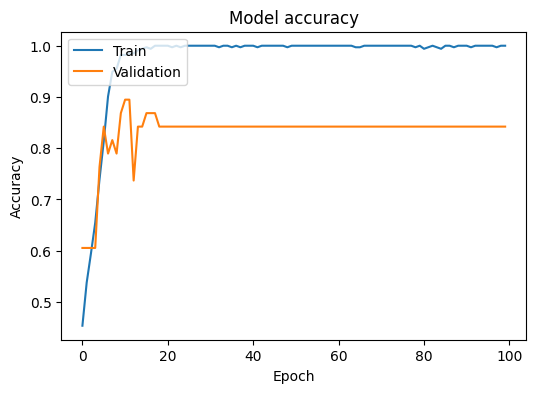

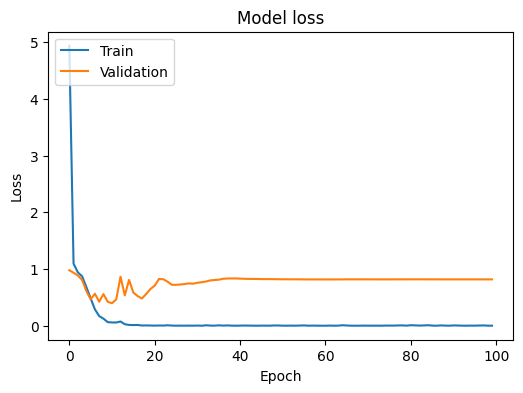

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


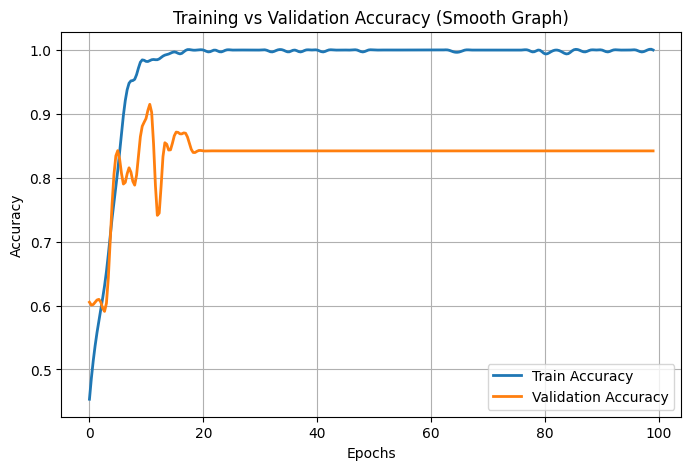

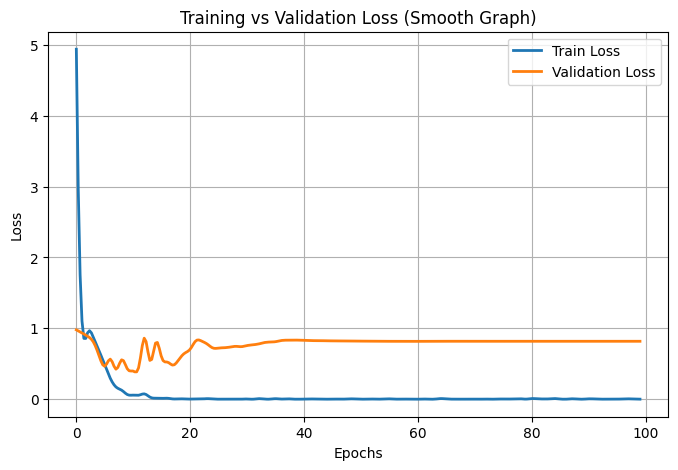

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Function to create smooth curves
def make_smooth(x, y, points=300):
    x_new = np.linspace(x.min(), x.max(), points)
    spline = make_interp_spline(x, y, k=3)  # Cubic spline
    y_new = spline(x_new)
    return x_new, y_new

epochs = np.arange(len(history.history['accuracy']))

# -----------------------------
# Smooth Accuracy
# -----------------------------
x_acc, y_acc = make_smooth(epochs, history.history['accuracy'])
x_val_acc, y_val_acc = make_smooth(epochs, history.history['val_accuracy'])

plt.figure(figsize=(8, 5))
plt.plot(x_acc, y_acc, label='Train Accuracy', linewidth=2)
plt.plot(x_val_acc, y_val_acc, label='Validation Accuracy', linewidth=2)
plt.title("Training vs Validation Accuracy (Smooth Graph)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# Smooth Loss
# -----------------------------
x_loss, y_loss = make_smooth(epochs, history.history['loss'])
x_val_loss, y_val_loss = make_smooth(epochs, history.history['val_loss'])

plt.figure(figsize=(8, 5))
plt.plot(x_loss, y_loss, label='Train Loss', linewidth=2)
plt.plot(x_val_loss, y_val_loss, label='Validation Loss', linewidth=2)
plt.title("Training vs Validation Loss (Smooth Graph)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the validation data
y_pred = model.predict([x_csv_val, x_img_val])

# Convert one-hot encoded y_val to class labels
y_true_classes = np.argmax(y_val, axis=1)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Overall Accuracy
overall_accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Overall Accuracy: {overall_accuracy:.4f}\n")

# Per-class metrics
for i, class_name in enumerate(classes):
    print(f"Metrics for class: {class_name}")
    # Precision
    precision = precision_score(y_true_classes == i, y_pred_classes == i, zero_division=0)
    print(f"  Precision: {precision:.4f}")

    # Recall
    recall = recall_score(y_true_classes == i, y_pred_classes == i, zero_division=0)
    print(f"  Recall: {recall:.4f}")

    # F1-Score
    f1 = f1_score(y_true_classes == i, y_pred_classes == i, zero_division=0)
    print(f"  F1-Score: {f1:.4f}\n")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Overall Accuracy: 0.8421

Metrics for class: Healthy
  Precision: 0.8148
  Recall: 0.9565
  F1-Score: 0.8800

Metrics for class: Fracture
  Precision: 1.0000
  Recall: 0.5000
  F1-Score: 0.6667

Metrics for class: pathological lesion
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000

Metrics for class: caries
  Precision: 0.8889
  Recall: 0.6667
  F1-Score: 0.7619



In [ ]:
!mkdir -p "/content/drive/MyDrive/Models"


In [ ]:
model.save("/content/drive/MyDrive/Models/dental_model.h5")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


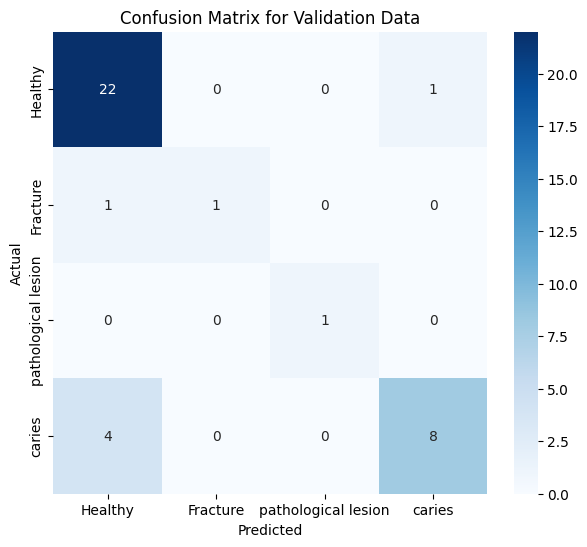

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Make predictions on the validation set
y_pred = model.predict([x_csv_val, x_img_val])

# Convert predictions to class labels (index of the max probability)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot encoding to class labels
y_true_classes = np.argmax(y_val, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.title("Confusion Matrix for Validation Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

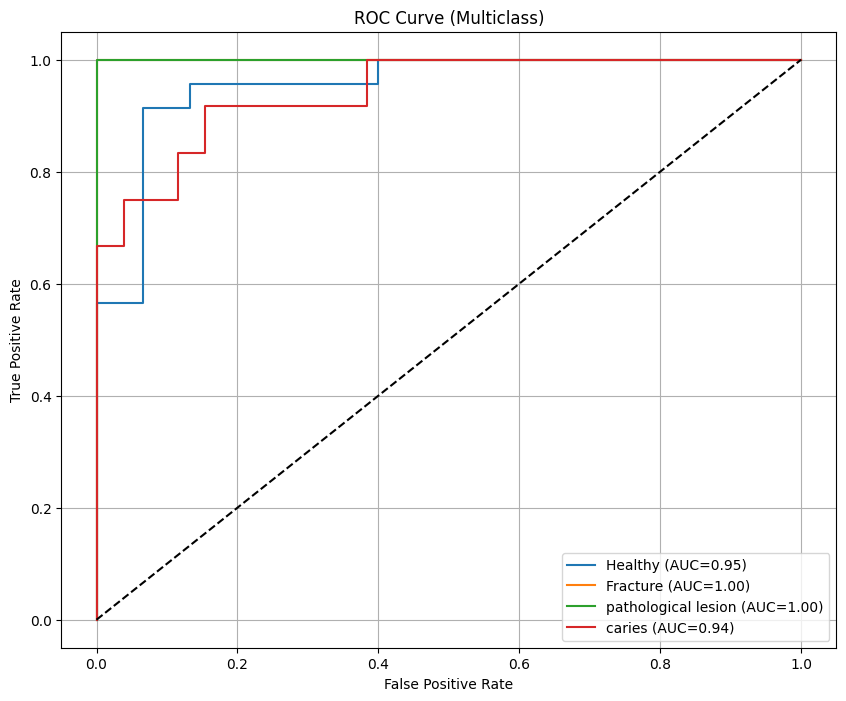

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# 'classes' variable is already defined globally from earlier cells
n_classes = len(classes)

# y_val is already one-hot encoded, so we can use it directly as y_true_bin
y_true_bin = y_val

# y_pred for validation data is already available from previous predictions
# If it wasn't, we would need to run: y_pred = model.predict([x_csv_val, x_img_val])

plt.figure(figsize=(10,8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve (Multiclass)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

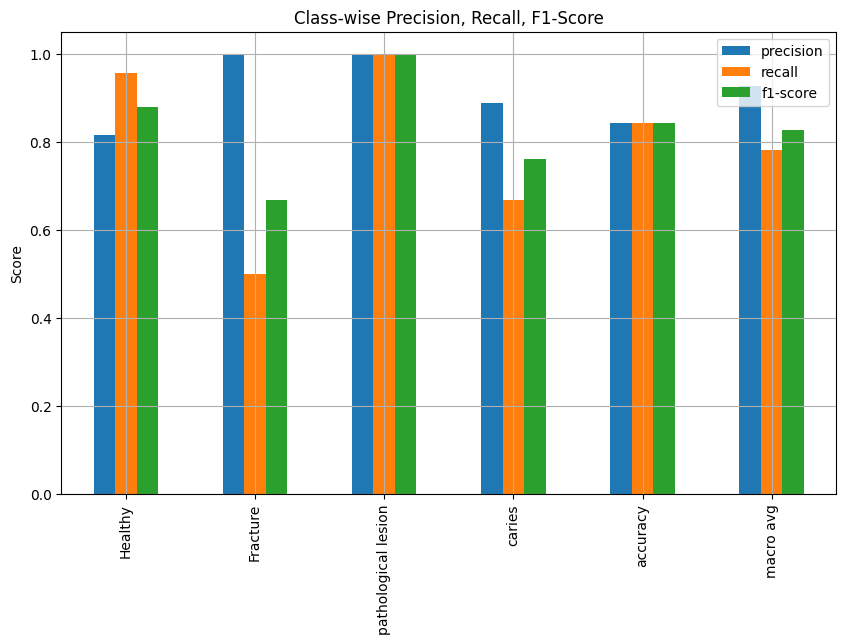

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true_classes, y_pred_classes, target_names=classes, output_dict=True)
df = pd.DataFrame(report).transpose()

df[['precision','recall','f1-score']].iloc[:-1].plot(kind='bar', figsize=(10,6))
plt.title("Class-wise Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.grid()
plt.show()

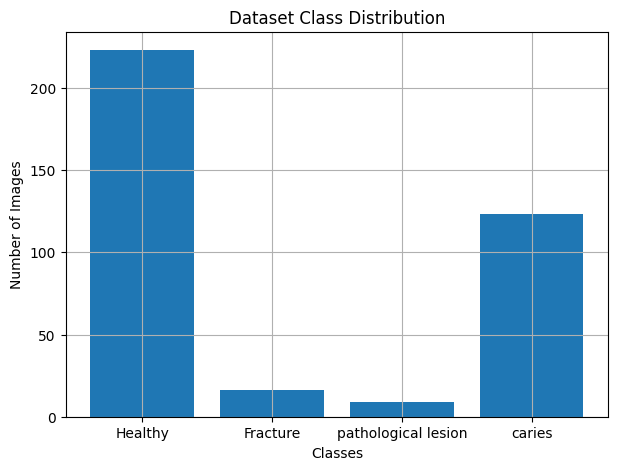

In [ ]:
plt.figure(figsize=(7,5))
plt.bar(classes, np.bincount(labels))
plt.title("Dataset Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.grid()
plt.show()


Upload an image :


Saving 2.jpg to 2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


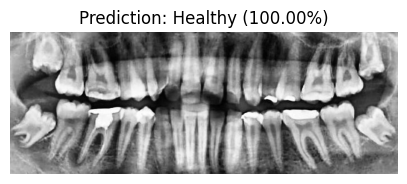


🔍 Prediction Breakdown:
Healthy             : 100.00%
Fracture            : 0.00%
pathological lesion : 0.00%
caries              : 0.00%

➡ Ready for next image...


Upload an image :


Saving 223.jpg to 223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


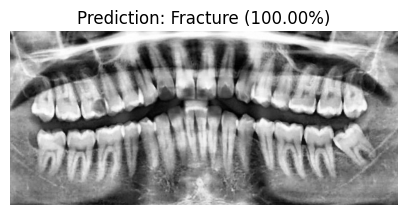


🔍 Prediction Breakdown:
Healthy             : 0.00%
Fracture            : 100.00%
pathological lesion : 0.00%
caries              : 0.00%

➡ Ready for next image...


Upload an image :


Saving 95.jpg to 95.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


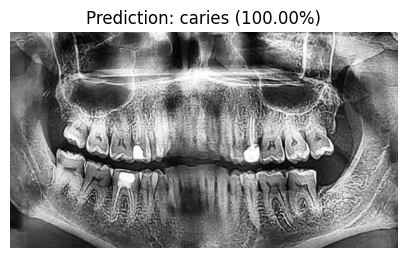


🔍 Prediction Breakdown:
Healthy             : 0.00%
Fracture            : 0.00%
pathological lesion : 0.00%
caries              : 100.00%

➡ Ready for next image...


Upload an image :


Saving 5.jpg to 5.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


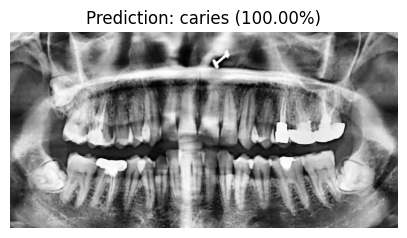


🔍 Prediction Breakdown:
Healthy             : 0.00%
Fracture            : 0.00%
pathological lesion : 0.00%
caries              : 100.00%

➡ Ready for next image...


Upload an image :


In [ ]:
import cv2
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# -------------------------------------------------------
# Load Trained Model
# -------------------------------------------------------
model = load_model("/content/drive/MyDrive/Models/dental_model.h5")

SIZE = 128
classes = ['Healthy', 'Fracture', 'pathological lesion', 'caries']


# -------------------------------------------------------
# Preprocessing Function
# -------------------------------------------------------
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (SIZE, SIZE))

    flat = img.flatten().astype('float32') / 255.0

    img2d = img.astype('float32') / 255.0
    img2d = np.expand_dims(img2d, axis=-1)

    return flat, img2d


# -------------------------------------------------------
# MULTI-IMAGE Prediction GUI
# -------------------------------------------------------
def multi_predict():
    while True:
        print("\nUpload an image :")
        uploaded = files.upload()

        if len(uploaded) == 0:
            print(" No file uploaded.")
            break

        for filename in uploaded.keys():
            flat, img2d = preprocess_image(filename)

            flat = np.expand_dims(flat, axis=0)
            img2d = np.expand_dims(img2d, axis=0)

            pred = model.predict([flat, img2d])[0]
            class_idx = np.argmax(pred)
            confidence = pred[class_idx] * 100

            plt.figure(figsize=(5,5))
            plt.imshow(cv2.imread(filename), cmap='gray')
            plt.title(f"Prediction: {classes[class_idx]} ({confidence:.2f}%)")
            plt.axis("off")
            plt.show()

            print("\n🔍 Prediction Breakdown:")
            for i, cls in enumerate(classes):
                print(f"{cls:20s}: {pred[i]*100:.2f}%")

        print("\n➡ Ready for next image...\n")


# -------------------------------------------------------
# RUN GUI
# -------------------------------------------------------
multi_predict()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 16384)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 16384, 1)  │          0 │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 128, 128,  │        320 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 16382, 32) │        128 │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 128, 128,  │     18,496 │ conv2d_24[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 16380, 64) │      6,208 │ conv1d_16[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 8190, 64)  │          0 │ conv1d_17[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 524160)    │          0 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 524288)    │          0 │ conv2d_26[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │ 67,092,608 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 128)       │ 67,108,992 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 128)       │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 128)       │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 256)       │          0 │ dropout_24[0][0], │
│ (Concatenate)       │                   │            │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │     32,896 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 64)        │      8,256 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 4)         │        260 │ dense_33[0][0]  

 Total params: 134,342,022 (512.47 MB)

 Trainable params: 134,342,020 (512.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

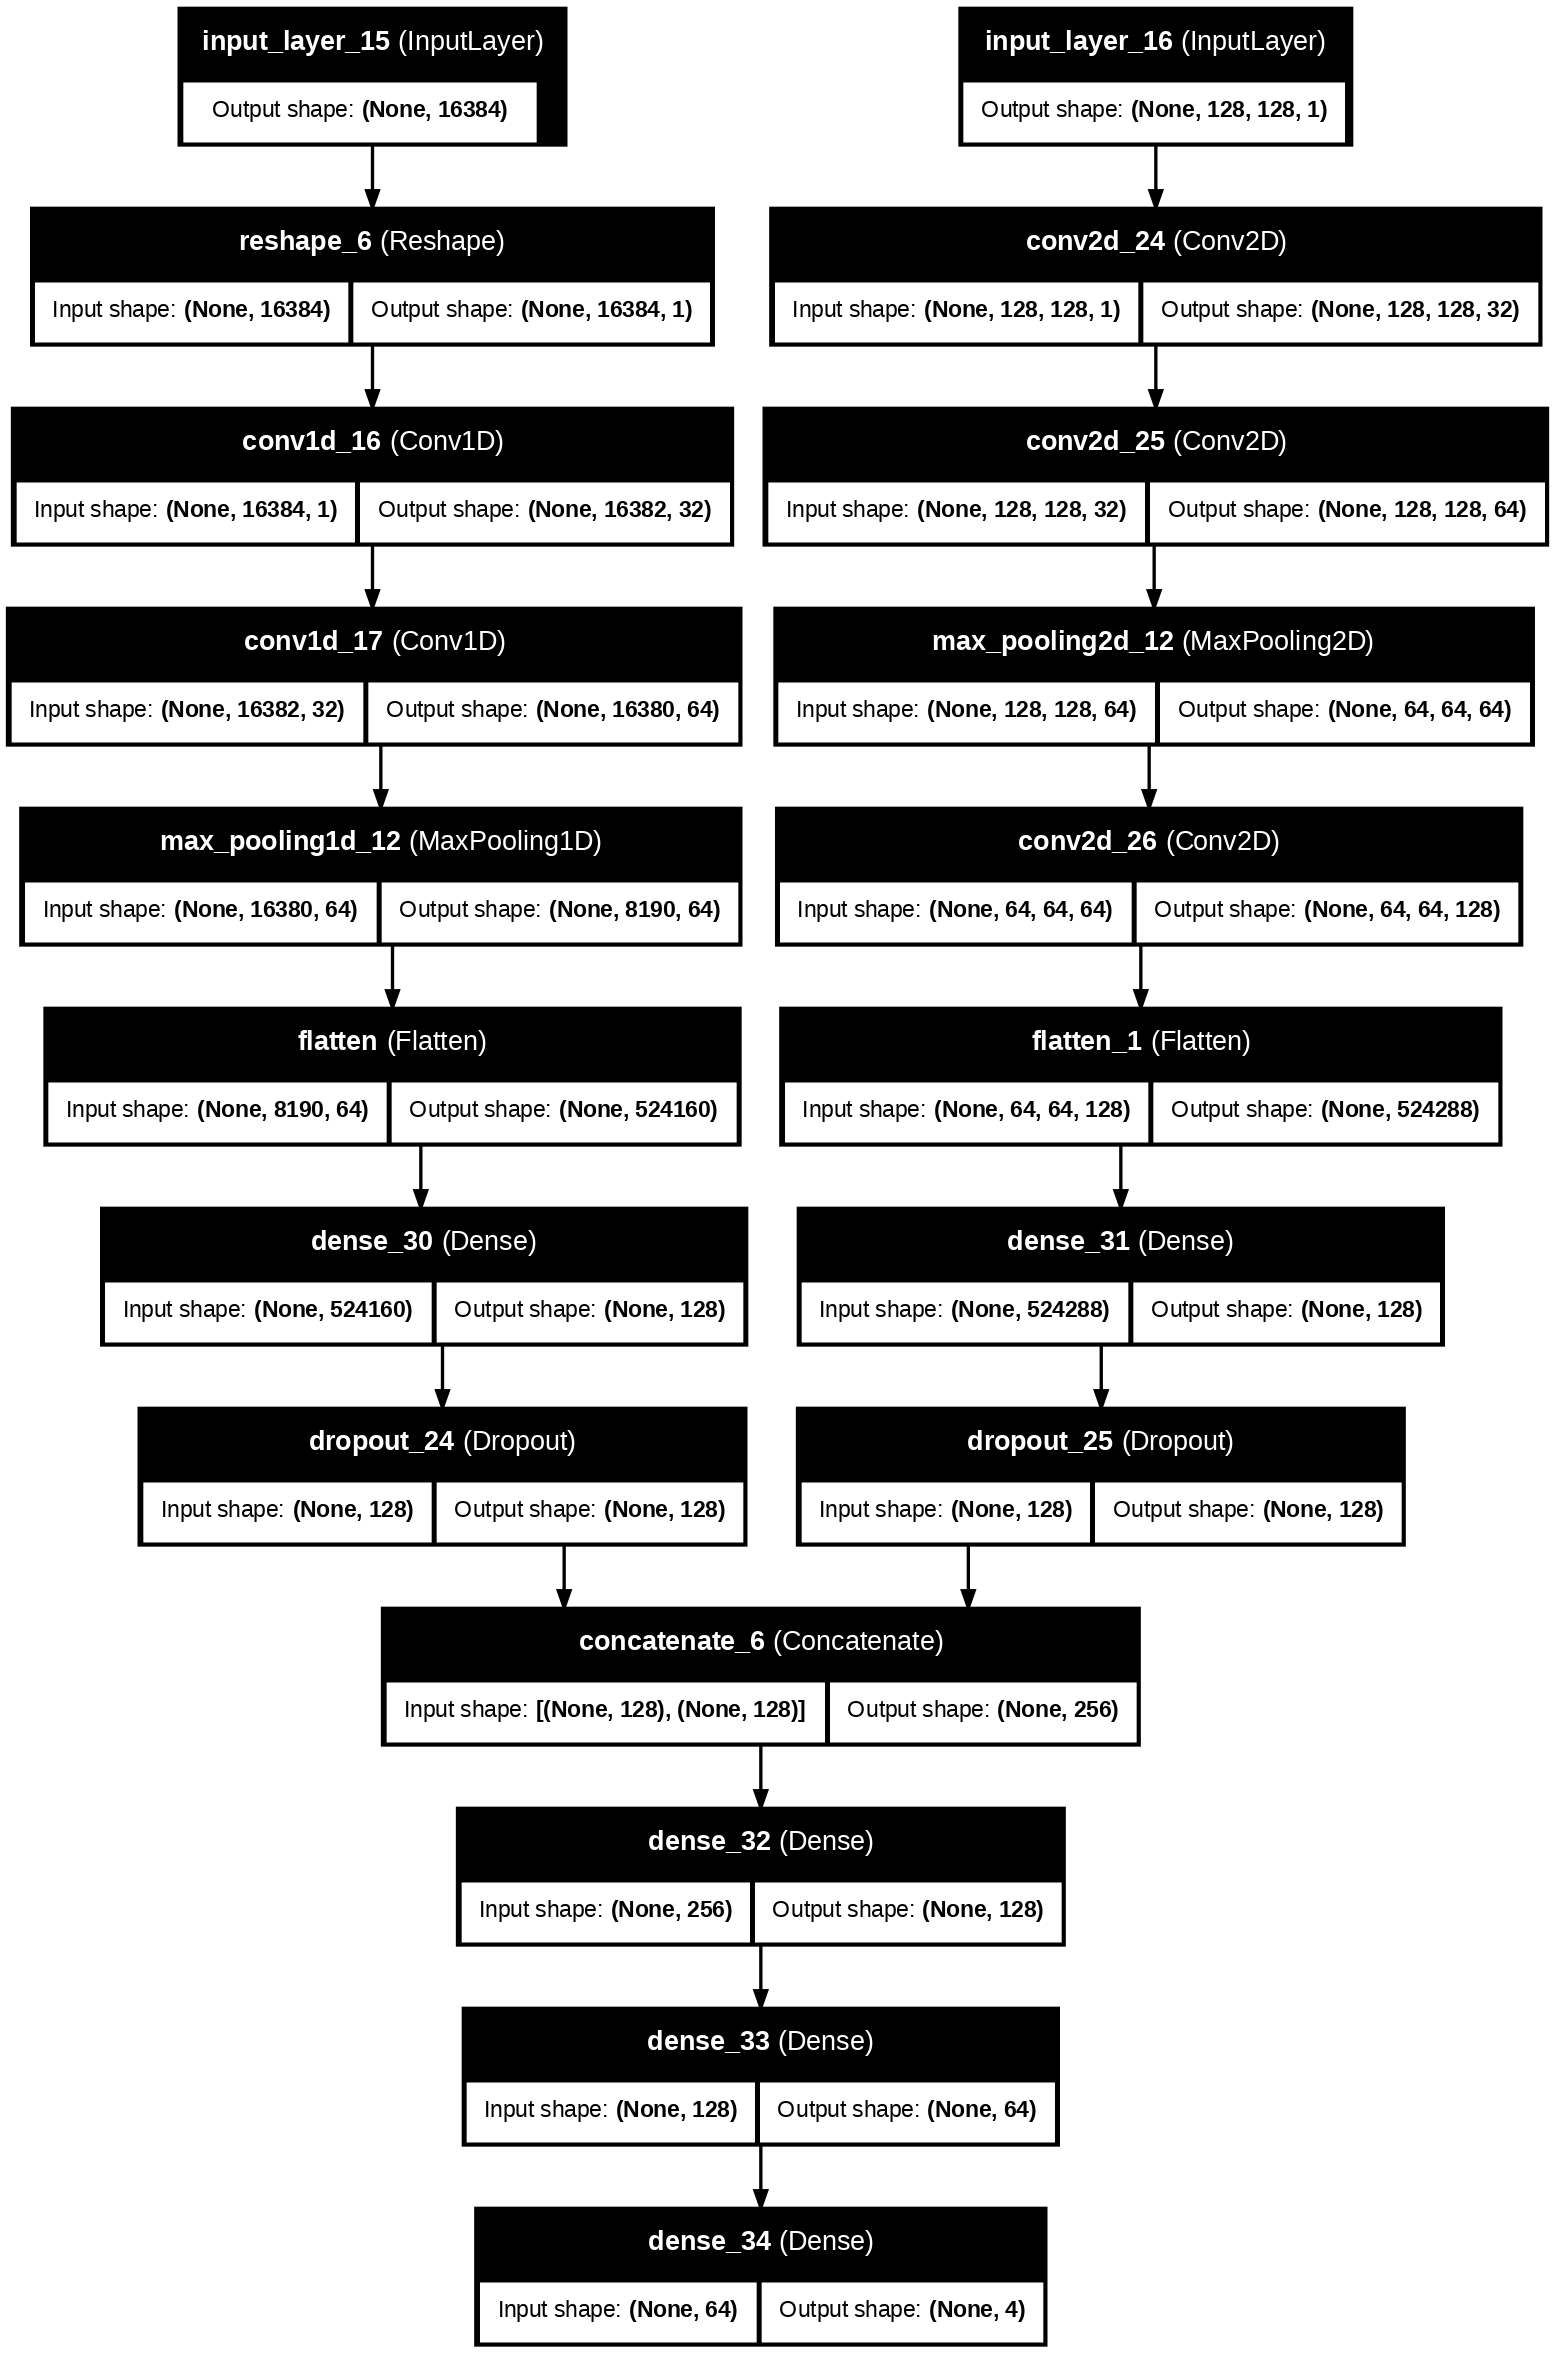

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# -------------------------------------------------------
# Load your saved model
# -------------------------------------------------------
model_path = "/content/drive/MyDrive/Models/dental_model.h5"
model = load_model(model_path)

# -------------------------------------------------------
# Print Model Summary (Text Block Diagram)
# -------------------------------------------------------
model.summary()

# -------------------------------------------------------
# Save Model Architecture Diagram
# -------------------------------------------------------
plot_model(
    model,
    to_file="dental_model_block_diagram.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=120
)

from IPython.display import Image
Image("dental_model_block_diagram.png")


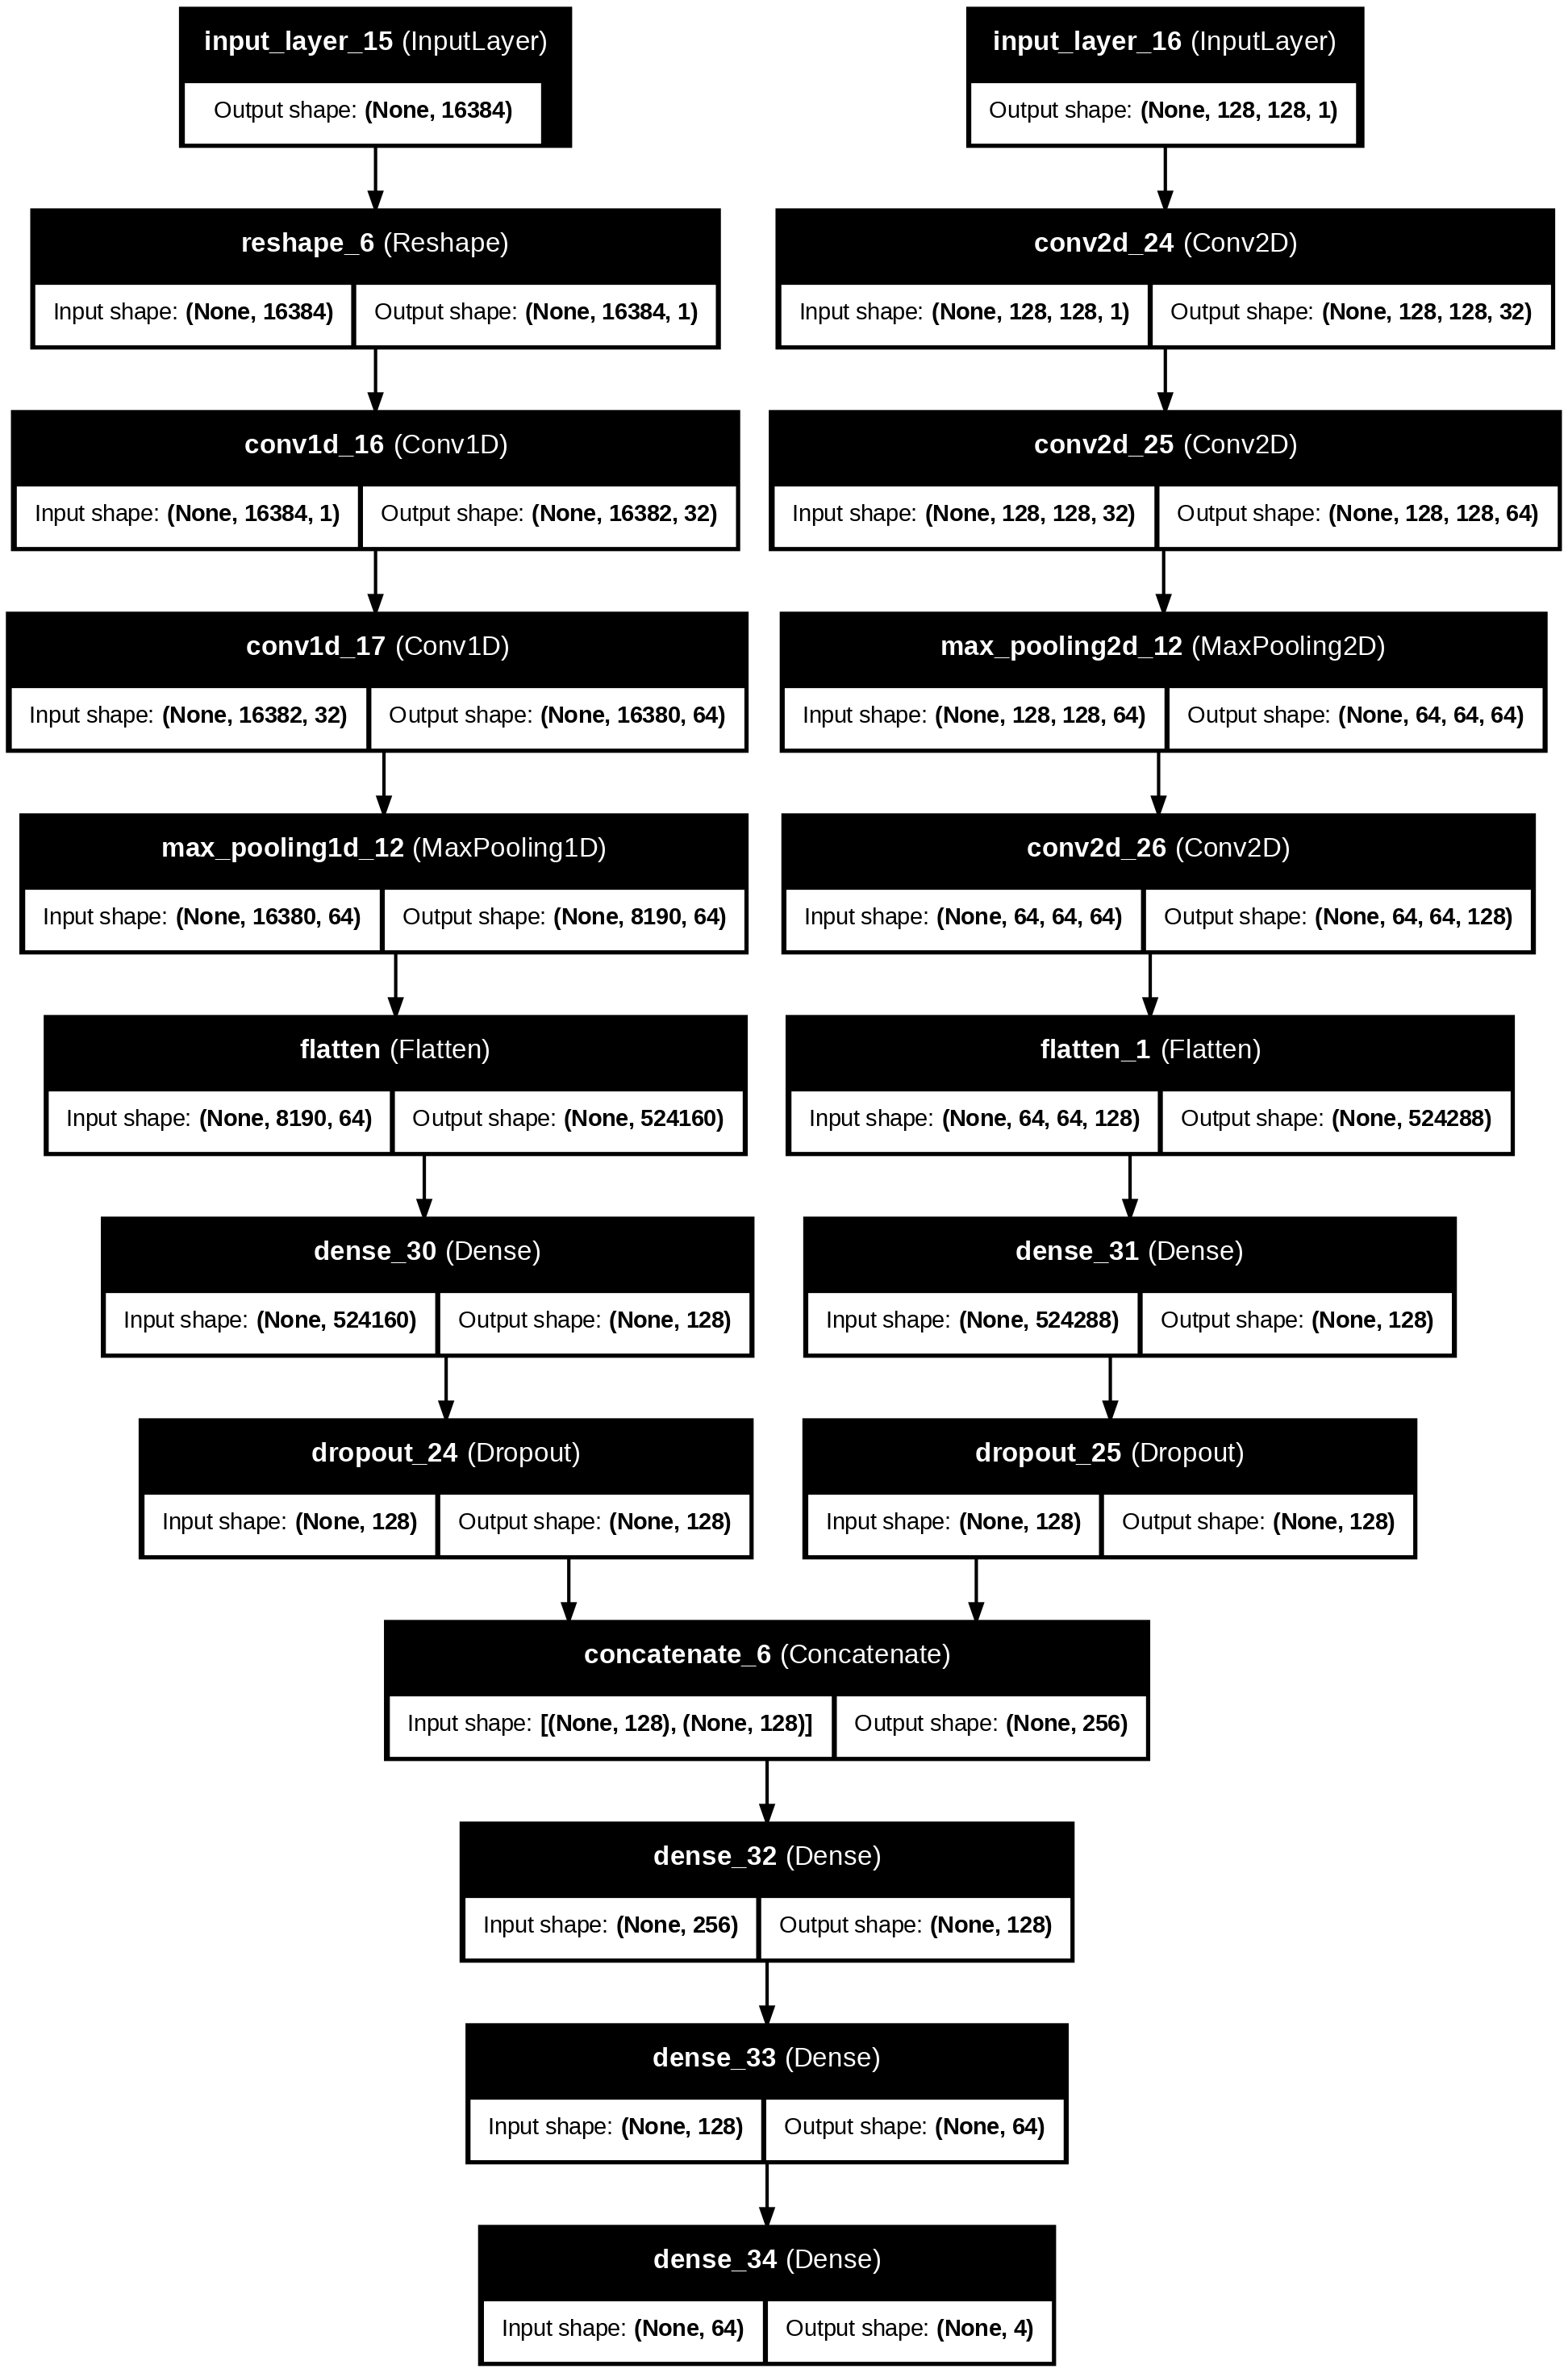

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Load model (no compile warning)
model = load_model("/content/drive/MyDrive/Models/dental_model.h5", compile=False)

# Save diagram
plot_model(
    model,
    to_file="multiple_inputs.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=150
)

# Display diagram in Google Colab
display(Image(filename="multiple_inputs.png"))


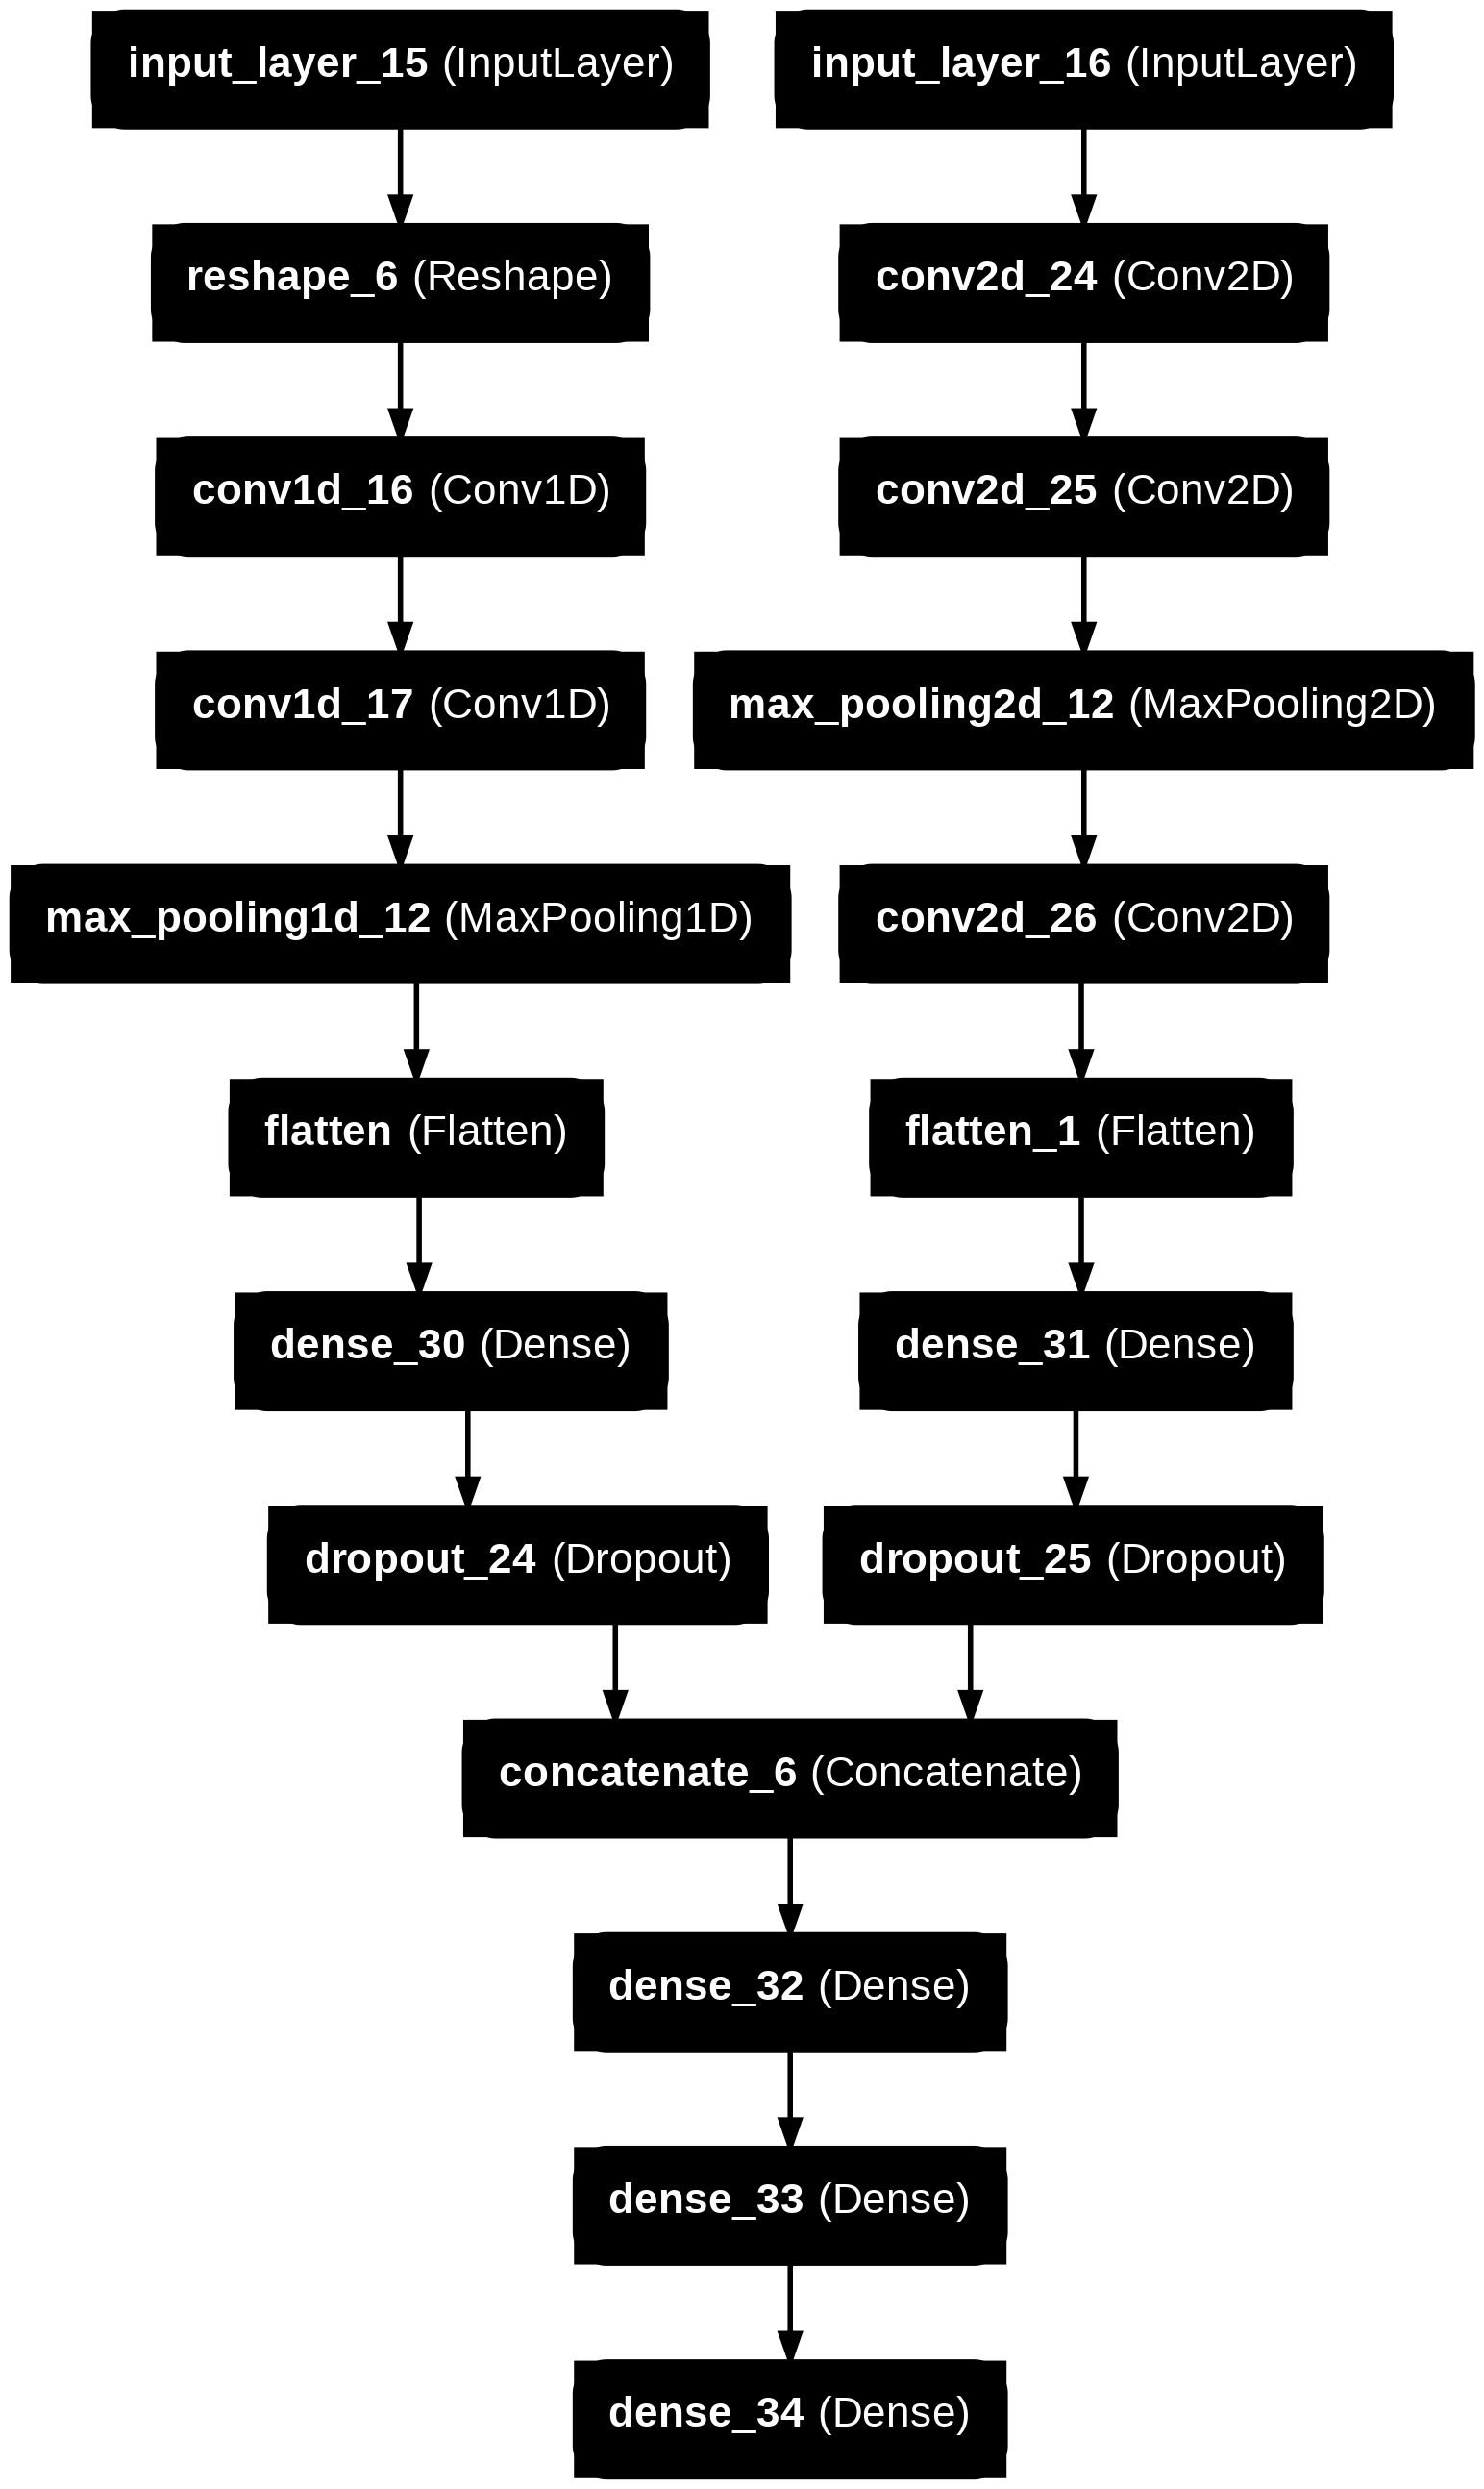

In [ ]:

import pydot
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.models import load_model
from IPython.display import Image, display

# Load your saved model
model = load_model("/content/drive/MyDrive/Models/dental_model.h5", compile=False)

# Convert model to dot format
dot_graph = model_to_dot(
    model,
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB"
)

# Convert dot to pydot graph
pydot_graph = pydot.graph_from_dot_data(dot_graph.to_string())[0]

# --------------------------------------------------------
# 🔥 FORCE PURE WHITE BLOCKS + WHITE BACKGROUND FIX
# --------------------------------------------------------
pydot_graph.set_bgcolor("white")

for node in pydot_graph.get_nodes():
    node.set_shape("box")
    node.set_style("rounded")
    node.set_fillcolor("white")
    node.set_color("black")
    node.set_fontcolor("black")

for edge in pydot_graph.get_edges():
    edge.set_color("black")

# Save final image
pydot_graph.write_png("white_blocks.png")

# Display reduced-size output in Colab
display(Image("white_blocks.png", width=400))
